In [1]:
# 1. Import libraries
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# 2. Load dataset
# =======================
data = pd.read_csv(r'C:\Users\Sahil\Documents\Job\Machine-Learning\india_housing_prices.csv')

# Quick overview
print("Dataset shape:", data.shape)
print(data.info())
display(data.head())

Dataset shape: (250000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              250000 non-null  int64  
 1   State                           250000 non-null  object 
 2   City                            250000 non-null  object 
 3   Locality                        250000 non-null  object 
 4   Property_Type                   250000 non-null  object 
 5   BHK                             250000 non-null  int64  
 6   Size_in_SqFt                    250000 non-null  int64  
 7   Price_in_Lakhs                  250000 non-null  float64
 8   Price_per_SqFt                  250000 non-null  float64
 9   Year_Built                      250000 non-null  int64  
 10  Furnished_Status                250000 non-null  object 
 11  Floor_No                        250000 non-null  i

,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move


In [3]:
# 3. Basic cleaning
# =======================
# Drop rows with missing target price
data = data.dropna(subset=['Price_in_Lakhs'])

# Optional: fill or drop missing features (here we fill with 'Unknown' or median)
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].fillna('Unknown')

for col in data.select_dtypes(exclude='object').columns:
    data[col] = data[col].fillna(data[col].median())

In [4]:
# 4. Split features and target
# =======================
X = data.drop('Price_in_Lakhs', axis=1)
y = data['Price_in_Lakhs']

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

print("Categorical columns:", list(cat_cols))
print("Numerical columns:", list(num_cols))

Categorical columns: ['State', 'City', 'Locality', 'Property_Type', 'Furnished_Status', 'Public_Transport_Accessibility', 'Parking_Space', 'Security', 'Amenities', 'Facing', 'Owner_Type', 'Availability_Status']
Numerical columns: ['ID', 'BHK', 'Size_in_SqFt', 'Price_per_SqFt', 'Year_Built', 'Floor_No', 'Total_Floors', 'Age_of_Property', 'Nearby_Schools', 'Nearby_Hospitals']


In [8]:
# 5. Preprocessing + Model pipeline
# =======================
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=30,
        max_depth=20,       # prevent overly deep trees
        max_features='sqrt',   # reduces computation per split
        n_jobs=3,          # use 3 CPU cores
        random_state=42
    ))
])

In [9]:
# 6. Train/test split
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# 7. Train Random Forest
# =======================
start = time.time()
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
end = time.time()

print("Training + Prediction time (sec):", round(end - start, 2))

Training + Prediction time (sec): 4.33


In [11]:
# --- Evaluate Model ---
print("\n--- Random Forest Performance ---")
print("Training time: {:.2f} seconds".format(end - start))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))


--- Random Forest Performance ---
Training time: 4.33 seconds
MAE: 99.35506201465681
RMSE: 115.63749670308682
R²: 0.3292354378245371


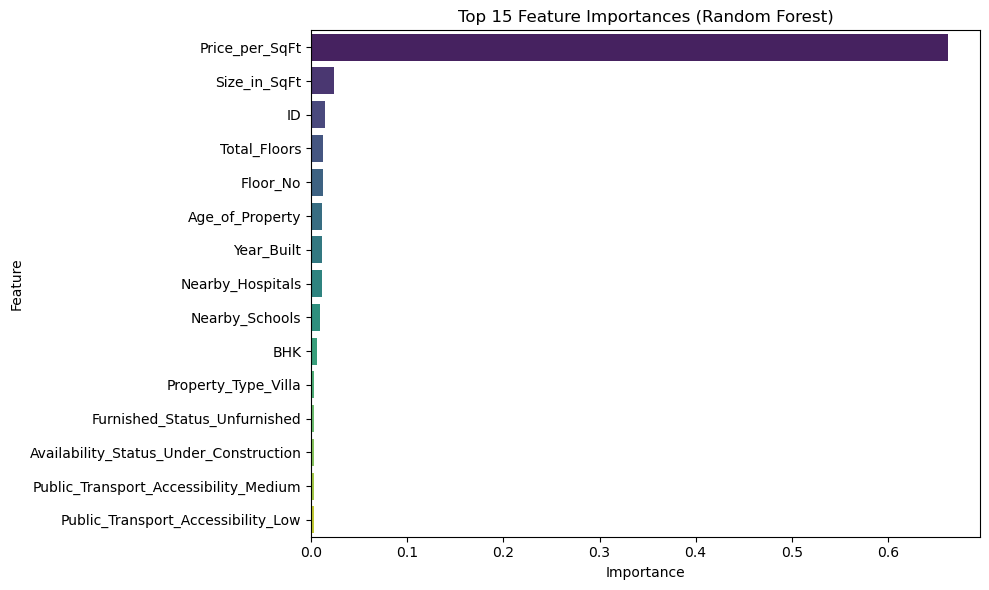

In [13]:
# 9. Feature Importance
# =======================
# Extract feature names after encoding
encoded_features = rf_pipeline.named_steps['preprocessor'] \
                               .transformers_[0][1] \
                               .get_feature_names_out(cat_cols)
all_features = np.concatenate([encoded_features, num_cols])

# Get feature importances from model
importances = rf_pipeline.named_steps['model'].feature_importances_
feat_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', 
            data=feat_imp, palette='viridis', legend=False)
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()